In [2]:
import json
import copy

import numpy as np
from scipy import optimize
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib.gridspec as gridspec

from defect_thermodynamics import DefectThermodynamics

from jax import grad, jit, vmap
import nlopt
import nevergrad as ng

import warnings
warnings.filterwarnings(action='once')


light_grey = '#EEEEEE'
lighter_grey = '#F5F5F5'
markers = ['d', 'P', 'o']
colors = ['#74a9cf','#0570b0','#023858']
font = {'size': 16}
linewidth = 2
markersize = 2

In [3]:
def defect_label_formatter(defect_string):
    comps = defect_string.split('_')
    new_string = f'{comps[0]}$_\mathrm{{{comps[1]}}}^{{{comps[2]}}}$'
    return new_string


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence \m


# Intrinsic defects

/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,V_Cd,V_Se,Cd_Se,Se_Cd,Cd_int,Se_int
charge,,,,,,
-3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
-2,9.795416e+09,0.000000e+00,0.000000e+00,7.731855e-15,0.000000e+00,1.501990e-08
-1,1.099661e+08,0.000000e+00,0.000000e+00,6.626870e+02,0.000000e+00,1.076528e-01
0,8.160531e+06,7.233372e+01,5.338347e-14,1.151479e+06,2.099947e+00,1.784759e+03
1,0.000000e+00,1.655979e+02,3.111093e-08,2.002955e+07,2.257163e+06,2.415515e+04
2,0.000000e+00,1.108262e+07,8.142291e-06,1.115312e+06,7.174850e+08,2.250998e+03
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


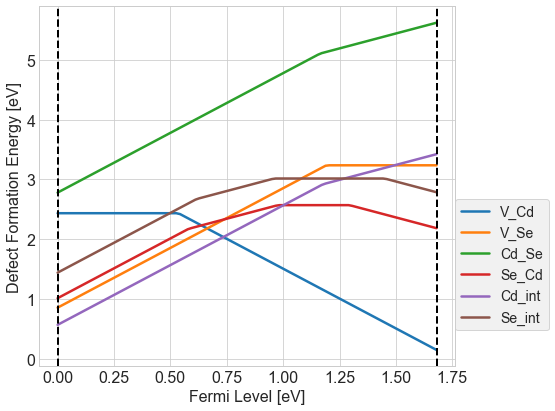

In [9]:
test_thermo = DefectThermodynamics.from_json('params_CdSe_wz.json',
                                             excluded_defects=['Cu_Cd', 'Cu_int'])

H_CdSe = -1.45
H_CuSe = -0.53

chem_pots = [H_CdSe, 0, 0, H_CuSe, 0, 0]
plt = test_thermo.formation_energy_plot(chem_pots)

test_thermo.defect_concentrations_dataframe(chem_pots, 0.78, 800) 

In [90]:
temperature = 800
final_temperature = 300
muCds = np.linspace(H_CdSe, 0, 100)

nholes = np.zeros(muCds.shape)
nelectrons = np.zeros(muCds.shape)
efermis = np.zeros(muCds.shape)

defect_concentrations = {"V_Cd": {"0": np.zeros(muCds.shape), 
                                  "-2": np.zeros(muCds.shape)},
                         "V_Se": {"0": np.zeros(muCds.shape),
                                  "2": np.zeros(muCds.shape)},
                         "Cd_Se": {"2": np.zeros(muCds.shape)},
                         "Se_Cd": {"0": np.zeros(muCds.shape), 
                                   "1": np.zeros(muCds.shape),
                                   "2": np.zeros(muCds.shape)},
                         "Cd_int": {"0": np.zeros(muCds.shape), 
                                   "1": np.zeros(muCds.shape)},
                         "Se_int": {"0": np.zeros(muCds.shape), 
                                   "1": np.zeros(muCds.shape),
                                   "2": np.zeros(muCds.shape)},
#                          "Cu_Cd": {"-1": np.zeros(muCds.shape)},
#                          "Cu_int": {"1": np.zeros(muCds.shape)},
                        }

nholes_quench = np.zeros(muCds.shape)
nelectrons_quench = np.zeros(muCds.shape)
efermis_quench = np.zeros(muCds.shape)

defect_concentrations_quench = copy.deepcopy(defect_concentrations)


for i, mucd in enumerate(muCds):
    chem_pots = [mucd, H_CdSe-mucd, 0, -0.5, 0, 0]
    ef_tmp = test_thermo.solve_for_fermi_energy(chem_pots, temperature)
    h_tmp, e_tmp = test_thermo.charge_carriers(ef_tmp, temperature)
    
    df_tmp = test_thermo.defect_concentrations_dataframe(chem_pots, ef_tmp, temperature)
    for dlabel, dconc_dict in defect_concentrations.items():
        for qstate, dconc in dconc_dict.items():
            dconc[i] = df_tmp[dlabel].loc[int(qstate)]
        
    nholes[i] = h_tmp
    nelectrons[i] = e_tmp
    efermis[i] = ef_tmp
                           
    ### Quench to 300 K
    high_temp_conc = test_thermo.defect_concentrations(chem_pots, ef_tmp, temperature)
    efq_tmp = test_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, final_temperature, temperature)
    hq_tmp, eq_tmp = test_thermo.charge_carriers(efq_tmp, final_temperature)
    
    low_temp_conc = test_thermo.redistribute_defect_charge_states(high_temp_conc, efq_tmp, final_temperature)
    for j, (dlabel, dconc_dict) in enumerate(defect_concentrations_quench.items()):
        for qstate, dconc in dconc_dict.items():
            dconc[i] = low_temp_conc[j][int(qstate) + 3]
                          
    nholes_quench[i] = hq_tmp
    nelectrons_quench[i] = eq_tmp
    efermis_quench[i] = efq_tmp


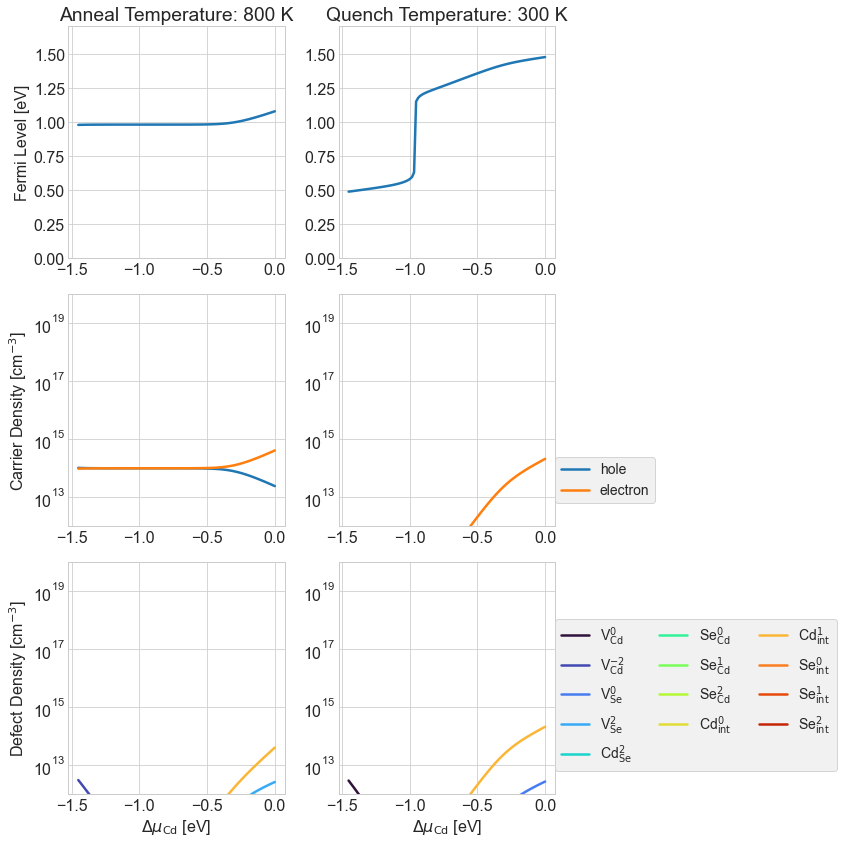

In [91]:
fig = plt.figure(tight_layout=True, figsize=(12,12))
gs = gridspec.GridSpec(3,2)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(3)]


axes[0][0].plot(muCds, efermis, label=None,
                linestyle='-', linewidth=2.5)
axes[0][1].plot(muCds, efermis_quench, label=None,
                linestyle='-', linewidth=2.5)

axes[0][0].set_ylim((0.0,1.7))
axes[0][1].set_ylim((0.0,1.7))
axes[0][0].set_ylabel(r'Fermi Level [eV]')
axes[0][0].set_title(f'Anneal Temperature: {temperature} K')
axes[0][1].set_title(f'Quench Temperature: {final_temperature} K')



axes[1][0].plot(muCds, nholes, label='hole',
                linestyle='-', linewidth=2.5)
axes[1][0].plot(muCds, nelectrons, label='electron',
                linestyle='-', linewidth=2.5)
axes[1][1].plot(muCds, nholes_quench, label='hole',
                linestyle='-', linewidth=2.5)
axes[1][1].plot(muCds, nelectrons_quench, label='electron',
                linestyle='-', linewidth=2.5)

axes[1][0].set_yscale('log')
axes[1][1].set_yscale('log')

axes[1][0].set_ylim((1e12,1e20))
axes[1][1].set_ylim((1e12,1e20))

axes[1][0].set_ylabel(r'Carrier Density [cm$^{-3}$]')
axes[1][1].legend(loc=(1,0.1), frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=1)


n = sum([len(dc_item) for _,dc_item in defect_concentrations.items()])
colors = plt.cm.turbo(np.linspace(0.0,0.9,n))

color_idx = 0
for dlabel, dconc_dict in defect_concentrations.items():
    for qstate, dconc in dconc_dict.items():
        new_label = defect_label_formatter(dlabel + '_' + qstate)
        axes[2][0].plot(muCds, dconc, label=new_label, color=colors[color_idx],
                        linestyle='-', linewidth=2.5)
        color_idx += 1

color_idx = 0
for dlabel, dconc_dict in defect_concentrations_quench.items():
    for qstate, dconc in dconc_dict.items():
        new_label = defect_label_formatter(dlabel + '_' + qstate)
        axes[2][1].plot(muCds, dconc, label=new_label, color=colors[color_idx],
                        linestyle='-', linewidth=2.5)
        color_idx += 1

axes[2][0].set_yscale('log')
axes[2][1].set_yscale('log')

axes[2][0].set_ylim((1e12,1e20))
axes[2][1].set_ylim((1e12,1e20))
    
axes[2][0].set_ylabel(r'Defect Density [cm$^{-3}$]')
axes[2][1].legend(loc=(1,0.1), frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=3)

axes[2][0].set_xlabel(r'$\Delta \mu_\mathrm{Cd}$ [eV]')
axes[2][1].set_xlabel(r'$\Delta \mu_\mathrm{Cd}$ [eV]')



plt.rc('font', **font)
plt.tight_layout()
plt.show()
plt.close()



In [67]:
defect_thermo = DefectThermodynamics.from_json('params_CdSe_wz.json',
                                                excluded_defects=[])

def annealed_quantities(chem_pots, final_temperature, anneal_temp):
    ef_anneal = defect_thermo.solve_for_fermi_energy(chem_pots, anneal_temp)
    high_temp_conc = defect_thermo.defect_concentrations(chem_pots, ef_anneal, anneal_temp)
    ef = defect_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, final_temperature, anneal_temp)
    hole_conc, electron_conc = defect_thermo.charge_carriers(ef, final_temperature)
    low_temp_conc = defect_thermo.redistribute_defect_charge_states(high_temp_conc, ef, final_temperature)
    
    return ef, hole_conc, electron_conc, low_temp_conc

def objective_func(x, anneal_temp):
#     anneal_temp = args[0]
    chem_pots = [x[0], H_CdSe-x[0], 0, x[1], 0, 0]
    final_temperature = 300
    
    ef, hole_conc, electron_conc, low_temp_conc = annealed_quantities(chem_pots, 
                                                                      final_temperature, 
                                                                      anneal_temp)
    return ef


cons = ({'type': 'ineq', 'fun': lambda x:  H_CuSe - (H_CdSe-x[0]) - x[1]},
        {'type': 'ineq', 'fun': lambda x:  x[0] - H_CdSe})
bnds = ((H_CdSe, 0), (-2, 0))

# cons = () #({'type': 'ineq', 'fun': lambda x:  H_CuTe - (H_CdTe-x[0]) - x[1]})
# bnds = ((H_CdSe, 0),)

anneal_temps = np.arange(400, 1205, 25)
Cd_chem_pots = np.zeros(anneal_temps.shape)
Cu_chem_pots = copy.deepcopy(Cd_chem_pots)
efermis = copy.deepcopy(Cd_chem_pots)
hole_concentrations = copy.deepcopy(Cd_chem_pots)

x_init = [-1, -0.5]
for i, ann_temp in enumerate(anneal_temps):
#     opt = optimize.minimize(objective_func, x_init, args=[ann_temp], 
#                             method='SLSQP', options={'ftol': 1e-10},
#                             bounds=bnds)
    
#     minimizer_kwargs = {"method": "SLSQP", "bounds": bnds, "args": [ann_temp],
#                         "constraints": cons, "options":{'ftol': 1e-10}}
#     opt = optimize.basinhopping(objective_func, x_init, 
#                                 minimizer_kwargs=minimizer_kwargs,
#                                 niter=100)

    minimizer_kwargs = {"method": "COBYLA"}
    opt = optimize.shgo(objective_func, bnds, n=64, iters=3,
                        args=(ann_temp,), constraints=cons,
                        options={'tol': 1e-10}, 
                        minimizer_kwargs=minimizer_kwargs)
    
    x_init = opt.x
    
    Cd_chem_pots[i] = opt.x[0]
    Cu_chem_pots[i] = opt.x[1]
    
    print(f' Step {i} | temp {ann_temp} |', opt.x)
    
    chem_pots = [opt.x[0], H_CdSe-opt.x[0], 0, opt.x[1], 0, 0]
    final_temperature = 300
    ef, hole_conc, electron_conc, low_temp_conc = annealed_quantities(chem_pots, 
                                                                      final_temperature, 
                                                                      ann_temp)
    efermis[i] = ef
    hole_concentrations[i] = hole_conc


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:86: RuntimeWarning: overflow encountered in exp
  pred = lambda x: KT**(1.5) * self.pref_v * np.sqrt(x) / (1 + np.exp( (x - eta_Fv) ))


 Step 0 | temp 400 | [-1.45 -0.53]
 Step 1 | temp 425 | [-1.45 -0.53]
 Step 2 | temp 450 | [-1.45 -0.53]
 Step 3 | temp 475 | [-1.45 -0.53]
 Step 4 | temp 500 | [-1.45 -0.53]
 Step 5 | temp 525 | [-1.45 -0.53]
 Step 6 | temp 550 | [-1.45 -0.53]
 Step 7 | temp 575 | [-1.45 -0.53]
 Step 8 | temp 600 | [-1.45 -0.53]
 Step 9 | temp 625 | [-1.45 -0.53]
 Step 10 | temp 650 | [-1.45 -0.53]
 Step 11 | temp 675 | [-1.45 -0.53]
 Step 12 | temp 700 | [-1.45 -0.53]
 Step 13 | temp 725 | [-1.45 -0.53]
 Step 14 | temp 750 | [-1.45 -0.53]
 Step 15 | temp 775 | [-1.45 -0.53]
 Step 16 | temp 800 | [-1.45 -0.53]
 Step 17 | temp 825 | [-1.45 -0.53]
 Step 18 | temp 850 | [-1.45 -0.53]
 Step 19 | temp 875 | [-1.45 -0.53]
 Step 20 | temp 900 | [-1.45 -0.53]
 Step 21 | temp 925 | [-1.45 -0.53]
 Step 22 | temp 950 | [-1.45 -0.53]
 Step 23 | temp 975 | [-1.45 -0.53]
 Step 24 | temp 1000 | [-1.45 -0.53]
 Step 25 | temp 1025 | [-1.45 -0.53]
 Step 26 | temp 1050 | [-1.45 -0.53]
 Step 27 | temp 1075 | [-1.45 -0.53

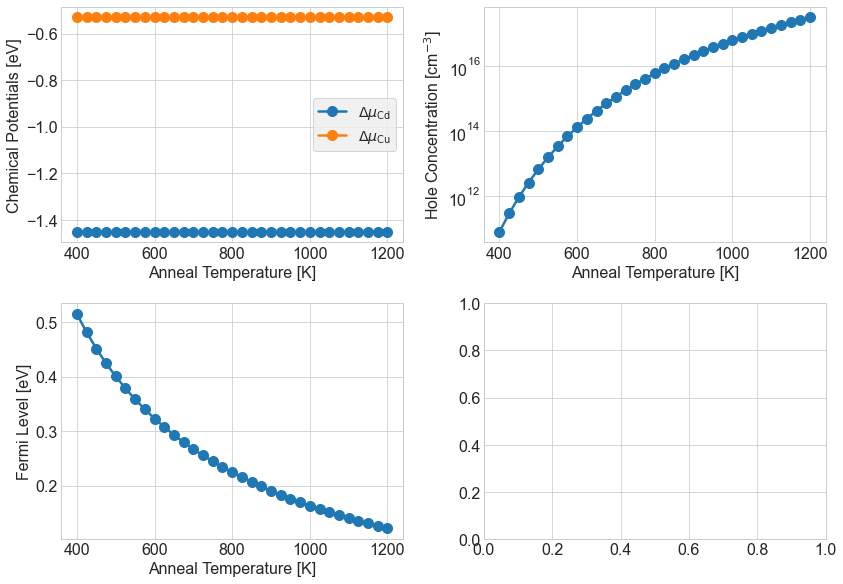

In [64]:
fig = plt.figure(tight_layout=True, figsize=(12,12))
gs = gridspec.GridSpec(3,2)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(2)]

axes[0][0].plot(anneal_temps, Cd_chem_pots, label=r'$\Delta \mu_\mathrm{Cd}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].plot(anneal_temps, Cu_chem_pots, label=r'$\Delta \mu_\mathrm{Cu}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].legend(loc='best', frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=1)
axes[0][0].set_xlabel('Anneal Temperature [K]')
axes[0][0].set_ylabel('Chemical Potentials [eV]')


axes[1][0].plot(anneal_temps, efermis, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][0].set_xlabel('Anneal Temperature [K]')
axes[1][0].set_ylabel('Fermi Level [eV]')


axes[0][1].plot(anneal_temps, hole_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][1].set_yscale('log')
axes[0][1].set_xlabel('Anneal Temperature [K]')
axes[0][1].set_ylabel(r'Hole Concentration [cm$^{-3}$]')


plt.rc('font', **font)
plt.tight_layout()
plt.show()
plt.close()